# Differential Gene Analysis

https://github.com/nithishak/differential-gene-analysis

In [1]:
#Download necessary libraries
library(GEOquery)
library(affy)
library(limma)

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with


In [2]:
##Downloading raw data from GEO series
#Extract phenodata and featuredata and relevant columns
gse <- getGEO("GSE31102", GSEMatrix = TRUE) #extracts info from series matrix file

Found 1 file(s)

GSE31102_series_matrix.txt.gz


── Column specification ────────────────────────────────────────────────────────
cols(
  ID_REF = col_character(),
  GSM770002 = col_double(),
  GSM770003 = col_double(),
  GSM770004 = col_double(),
  GSM770005 = col_double(),
  GSM770006 = col_double(),
  GSM770007 = col_double(),
  GSM770008 = col_double(),
  GSM770009 = col_double(),
  GSM770010 = col_double(),
  GSM770011 = col_double(),
  GSM770012 = col_double(),
  GSM770013 = col_double()
)


File stored at: 

/var/folders/z4/zq1sx9z918l822zf41yhflvr0000gn/T//RtmpvpuDuU/GPL8321.soft

Warning message:
“64 parsing failures.
  row     col           expected    actual         file
22627 SPOT_ID 1/0/T/F/TRUE/FALSE --Control literal data
22628 SPOT_ID 1/0/T/F/TRUE/FALSE --Control literal data
22629 SPOT_ID 1/0/T/F/TRUE/FALSE --Control literal data
22630 SPOT_ID 1/0/T/F/TRUE/FALSE --Control literal data
22631 SPOT_ID 1/0/T/F/TRUE/FALSE --Control literal data
..... ....... ...............

In [3]:
show(gse) #produces a list

$GSE31102_series_matrix.txt.gz
ExpressionSet (storageMode: lockedEnvironment)
assayData: 22690 features, 12 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: GSM770002 GSM770003 ... GSM770013 (12 total)
  varLabels: title geo_accession ... compound:ch1 (35 total)
  varMetadata: labelDescription
featureData
  featureNames: 1415670_at 1415671_at ... AFFX-TrpnX-M_at (22690 total)
  fvarLabels: ID GB_ACC ... Gene Ontology Molecular Function (16 total)
  fvarMetadata: Column Description labelDescription
experimentData: use 'experimentData(object)'
  pubMedIds: 22242153 
Annotation: GPL8321 



In [4]:
#phenoData
phenoData <- pData(gse[[1]]) 
colnames(phenoData) #view column names to understand different types of data available in phenoData

[1] "title"                   "geo_accession"          
 [3] "status"                  "submission_date"        
 [5] "last_update_date"        "type"                   
 [7] "channel_count"           "source_name_ch1"        
 [9] "organism_ch1"            "characteristics_ch1"    
[11] "characteristics_ch1.1"   "treatment_protocol_ch1" 
[13] "growth_protocol_ch1"     "molecule_ch1"           
[15] "extract_protocol_ch1"    "label_ch1"              
[17] "label_protocol_ch1"      "taxid_ch1"              
[19] "hyb_protocol"            "scan_protocol"          
[21] "description"             "data_processing"        
[23] "platform_id"             "contact_name"           
[25] "contact_email"           "contact_institute"      
[27] "contact_address"         "contact_city"           
[29] "contact_state"           "contact_zip/postal_code"
[31] "contact_country"         "supplementary_file"     
[33] "data_row_count"          "cell line:ch1"          
[35] "compound:ch1"

In [5]:
pd_df <- phenoData[,c(1,6,9,10,11)] #choose relevant columns 
names(pd_df) <- c('treatment_rep','biologicalUnit', 'organism', 'cellType', 'treatment') #rename relevant columns

In [6]:
pd<- AnnotatedDataFrame(pd_df) #change pd from dataframe to annotated dataframe in order to create ExpressionSet object later on

In [7]:
#featureData
featureData <- fData(gse[[1]])
colnames(featureData) #view column names to understand different types of data available in featureData
fd_df <- featureData[,11, drop = FALSE] #choose relevant column, in this case, Gene Symbols 
fd<- AnnotatedDataFrame(fd_df) #change pd from dataframe to annotated dataframe in order to create ExpressionSet object later on

[1] "ID"                               "GB_ACC"                          
 [3] "SPOT_ID"                          "Species Scientific Name"         
 [5] "Annotation Date"                  "Sequence Type"                   
 [7] "Sequence Source"                  "Target Description"              
 [9] "Representative Public ID"         "Gene Title"                      
[11] "Gene Symbol"                      "ENTREZ_GENE_ID"                  
[13] "RefSeq Transcript ID"             "Gene Ontology Biological Process"
[15] "Gene Ontology Cellular Component" "Gene Ontology Molecular Function"

In [9]:
#Extract raw data
filePaths <- getGEOSuppFiles('GSE31102') #downloads raw data into a folder(named as GSE31102) created in the current directory
filePaths #shows downloaded tar files, EXTRACT MANUALLY to cel.gz files in the same directory


No supplemental files found.

Check URL manually if in doubt



ERROR: Error in FUN(X[[i]], ...): cannot coerce type 'closure' to vector of type 'character'


In [10]:
data<- ReadAffy(celfile.path='/Users/sdeshpande/Desktop/gene_analysis/GSE31102/GSE31102_RAW/') #AffyBatch object created, make sure correct path to CEL.gz files specified
sampleNames(data) <- sub('.CEL.gz', '', sampleNames(data)) #renaming sample names(which are assayData column names) to reflect rownames in phenoData

In [11]:
#Normalize raw data and create an ExpressionSet object
es<- rma(data) #Normalization process is carried out (rma method) and an ExpressionSet object is created
head(exprs(es)) #to view assayCounts

phenoData(es) <- pd #add phenoData to ExpressionSet object, can be viewed using pData(es)
featureData(es) <- fd #add featureData to ExpressionSet object, can be viewed using fData(es)


installing the source package ‘mouse430a2cdf’


Warning message:
“replacing previous import ‘AnnotationDbi::tail’ by ‘utils::tail’ when loading ‘mouse430a2cdf’”
Warning message:
“replacing previous import ‘AnnotationDbi::head’ by ‘utils::head’ when loading ‘mouse430a2cdf’”




Background correcting
Normalizing
Calculating Expression


,GSM770002,GSM770003,GSM770004,GSM770005,GSM770006,GSM770007,GSM770008,GSM770009,GSM770010,GSM770011,GSM770012,GSM770013
1415670_at,10.45251,10.33611,10.462834,10.713258,10.752761,10.696916,11.71030,11.68877,11.74201,11.81265,11.836064,11.98836
1415671_at,12.10097,12.09337,12.107617,12.497256,12.491094,12.416342,12.26944,12.15662,12.26791,12.42508,12.503027,12.55456
1415672_at,12.12263,12.11680,12.132049,12.492791,12.515635,12.617631,11.33339,11.36288,11.35062,11.59568,11.596538,11.66743
1415673_at,11.23894,11.18176,11.188062,10.202779,10.319944,10.148064,11.41038,11.31827,11.37684,11.43794,11.412623,11.54138
1415674_a_at,9.92681,9.89710,9.961364,10.034085,10.037269,10.084891,10.10887,10.15159,10.14646,10.50191,10.465316,10.58955
1415675_at,10.13798,10.13279,10.242934,9.823793,9.897899,9.954239,10.03444,10.00547,10.00213,10.04768,9.980043,10.21951


In [12]:
#Normalize raw data and create an ExpressionSet object
es<- rma(data) #Normalization process is carried out (rma method) and an ExpressionSet object is created
head(exprs(es)) #to view assayCounts

Background correcting
Normalizing
Calculating Expression


,GSM770002,GSM770003,GSM770004,GSM770005,GSM770006,GSM770007,GSM770008,GSM770009,GSM770010,GSM770011,GSM770012,GSM770013
1415670_at,10.45251,10.33611,10.462834,10.713258,10.752761,10.696916,11.71030,11.68877,11.74201,11.81265,11.836064,11.98836
1415671_at,12.10097,12.09337,12.107617,12.497256,12.491094,12.416342,12.26944,12.15662,12.26791,12.42508,12.503027,12.55456
1415672_at,12.12263,12.11680,12.132049,12.492791,12.515635,12.617631,11.33339,11.36288,11.35062,11.59568,11.596538,11.66743
1415673_at,11.23894,11.18176,11.188062,10.202779,10.319944,10.148064,11.41038,11.31827,11.37684,11.43794,11.412623,11.54138
1415674_a_at,9.92681,9.89710,9.961364,10.034085,10.037269,10.084891,10.10887,10.15159,10.14646,10.50191,10.465316,10.58955
1415675_at,10.13798,10.13279,10.242934,9.823793,9.897899,9.954239,10.03444,10.00547,10.00213,10.04768,9.980043,10.21951


In [13]:
phenoData(es) <- pd #add phenoData to ExpressionSet object, can be viewed using pData(es)
featureData(es) <- fd #add featureData to ExpressionSet object, can be viewed using fData(es)

#subset es for only mouse alpha cells from phenoData cellType column
new_es <- es[,es$cellType == 'cell line: aTC1']

In [15]:
#design matrix
f <- factor(new_es$treatment, levels = c('compound: DMSO', 'compound: GW8510'))
design <- model.matrix(~0+f)
colnames(design) <- c('control', 'GW8510_cpd')
fit<- lmFit(new_es,design)

In [16]:
#contrast matrix and differential gene analysis
contrast.matrix <- makeContrasts( GW8510_cpd-control, control-GW8510_cpd, levels= design) #create different comparison groups
fit2 <- contrasts.fit(fit,contrast.matrix)
fit2 <- eBayes(fit2)

In [17]:
#View results for the comparison- GW8510_cpd-control (coef=1 in contrast.matrix)
a_ctrl<- topTable(fit2, coef=1, adjust='BH', sort.by='logFC', resort.by = 'logFC', p.value=0.05, number= Inf) #Sort results by logFc values(biggest to smallest, adjusted p value cutoff os 0.05 and we want to view all genes)
a_ctrl_volcano_plot <- topTable(fit2, coef=1, adjust='BH', sort.by='logFC', resort.by = 'logFC', number= Inf) # we want all genes regardless of adjusted p values to plot volcano plot
print (head(a_ctrl))

                   Gene.Symbol    logFC   AveExpr        t      P.Value
1452757_s_at Hba-a1 /// Hba-a2 7.021102  9.133838 58.89279 1.624742e-10
1417466_at                Rgs5 5.637741  8.575252 95.84571 5.820556e-12
1422438_at               Ephx1 5.042298 10.251101 58.35157 1.730513e-10
1453265_at                Eqtn 4.626061  6.503743 50.15449 4.865634e-10
1420941_at                Rgs5 4.445284  7.919159 40.08929 2.243103e-09
1428361_x_at Hba-a1 /// Hba-a2 4.444638 10.195907 43.57409 1.270513e-09
                adj.P.Val        B
1452757_s_at 6.161304e-07 14.65885
1417466_at   1.320684e-07 16.61978
1422438_at   6.161304e-07 14.61298
1453265_at   7.254376e-07 13.81843
1420941_at   1.413778e-06 12.51037
1428361_x_at 9.940669e-07 13.01393


In [18]:
a_ctrl_volcano_plot

,Gene.Symbol,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1452757_s_at,Hba-a1 /// Hba-a2,7.021102,9.133838,58.89279,1.624742e-10,6.161304e-07,14.658850
1417466_at,Rgs5,5.637741,8.575252,95.84571,5.820556e-12,1.320684e-07,16.619780
1422438_at,Ephx1,5.042298,10.251101,58.35157,1.730513e-10,6.161304e-07,14.612976
1453265_at,Eqtn,4.626061,6.503743,50.15449,4.865634e-10,7.254376e-07,13.818430
1420941_at,Rgs5,4.445284,7.919159,40.08929,2.243103e-09,1.413778e-06,12.510369
1428361_x_at,Hba-a1 /// Hba-a2,4.444638,10.195907,43.57409,1.270513e-09,9.940669e-07,13.013926
1452141_a_at,Sepp1,4.183472,9.999562,85.93076,1.228183e-11,1.393374e-07,16.259757
1451690_a_at,Pvrl4,4.002550,8.127673,32.24811,9.877878e-09,2.700350e-06,11.116577
1424400_a_at,Aldh1l1,3.674636,9.529755,47.67557,6.877117e-10,7.802089e-07,13.535419


In [ ]:
#write results to csv files
write.csv(a_ctrl, file = '/Users/sdeshpande/Desktop/gene_analysis/GSE31102/A-control_stringent.csv') #please save as filename_stringent.csv for future file manipulation
write.csv(a_ctrl_volcano_plot, file = '/Users/sdeshpande/Desktop/gene_analysis/GSE31102/A-control_volcano_plot.csv') #please save as filename_volcano_plot.csv for future file manipulation

# Upregulated_downregulated_genes

In [35]:
upreg_downreg_gene <- function(file_name){
  #Read results file
  dge_results <- read.csv(file_name,sep =',', stringsAsFactors = FALSE, check.names = FALSE)
  #Remove NA values for gene names in column for gene symbols
  dge_results <- dge_results[!is.na(dge_results$Gene.Symbol),]
  
  
  #20 most up-regulated genes (treatment-ctrl LogFC is +ve)
  target <- 20
  target_reached<- FALSE
  while(!target_reached){
    upreg <- dge_results[1:target,]
    if (length(unique(upreg$Gene.Symbol)) < 20){
      target<- target + 1
    }
    else{
      target_reached <- TRUE
      upreg_n <- upreg[!duplicated(upreg$Gene.Symbol), c("Gene.Symbol", "logFC")]
      #print (upreg_n)
      upreg_n$regulation <- "upregulated genes"
      colnames(upreg_n) <- c("Genes", "LogFC", "Regulation")
    }
  }

  #20 most down-regulated genes (treatment-ctrl LogFC is -ve)
  rows <- nrow(dge_results)
  target = 19
  target_reached<- FALSE
  while(!target_reached){
    downreg <- dge_results[(rows-target):rows,]
    if (length(unique(downreg$Gene.Symbol)) < 20){
      target<- target + 1
    }
    else{
      target_reached <- TRUE
      downreg_n <- downreg[!duplicated(downreg$Gene.Symbol), c("Gene.Symbol", "logFC")]
      downreg_n$regulation <- "downregulated genes"
      colnames(downreg_n) <- c("Genes", "LogFC", "Regulation")
    }
  }
  
  gene_list <- rbind(upreg_n,downreg_n)
  save_file_name <- sub('.*/', '', file_name)
  save_file_name_modified <- sub('stringent', 'upreg_downreg', save_file_name)
  write.csv(gene_list, file = save_file_name_modified, row.names = FALSE)
  
 }

In [36]:
upregDownregGeneList <- upreg_downreg_gene('/Users/sdeshpande/Desktop/gene_analysis/GSE31102/A-control_stringent.csv')
# check the csv file for top 20 upregulated and downregulated genes

In [38]:
#Inputs
file_path <- '/Users/sdeshpande/Desktop/gene_analysis/GSE31102/'
file_pattern <- '_volcano_plot.csv'

In [37]:
#Download necessary libraries
library(ggplot2)
library(ggrepel)

volcano_plot <- function(file_name){
  #Read results file from ./Results
  vp <- read.csv(file_name,sep =',', stringsAsFactors = FALSE, row.names = 1, check.names = FALSE)
  
  #This is to color code red for genes for which adj p value < 0.05 and grey for others.
  #Create a new column called "Significant" which labels "FDR<0.05" is adj p value is less than 0.05, and "Not Sig" is not.
  vp$Significant <- ifelse (vp$adj.P.Val<0.05, "FDR<0.05", "Not Sig")
  
  #This is to label top 20 upregulated and top 20 downregulated genes in the volcano plot.
  #Subset a new df that contains only sig genes based on adj p value.
  vp_sig <- subset(vp, adj.P.Val < 0.05)
  #Choose first 20 rows, based on logFC values, afinal contains sorted logFC values from largest to smallest logFC values.
  upreg <- vp_sig[1:20,]
  #Choose the last 20 rows, based on logFC values.
  rows<- nrow(vp_sig)
  target = 19
  downreg <- vp_sig[(rows-target):rows,]
  #Combine upreg and downreg genes into one df.
  sig_genes <- rbind(upreg,downreg)
 
  #Plot volcano plot
  volcanoPlot <- ggplot(vp, aes(logFC,-log10(P.Value), color= Significant)) +
    geom_point() +
    scale_color_manual(values = c("red","grey")) +
    theme_bw (base_size = 16) +
    geom_text_repel (data= sig_genes, aes(label= Gene.Symbol), size= 3, box.padding = 0.25, point.padding = 0.3, color = "black")
    
  print (volcanoPlot)
  image_name <- sub('.*/', '', file_name) #using file name, remove path in front of file name eg. 'path/file_name.csv' changed to 'file_name.csv'
  image_name_modified <- paste0(sub('.csv', '' , image_name), '.png') # replace .csv from image_name to '.png' eg. 'file_name.csv' to 'file_name.png'
  ggsave(image_name_modified, width =8, height = 6, dpi = 84)
  
}

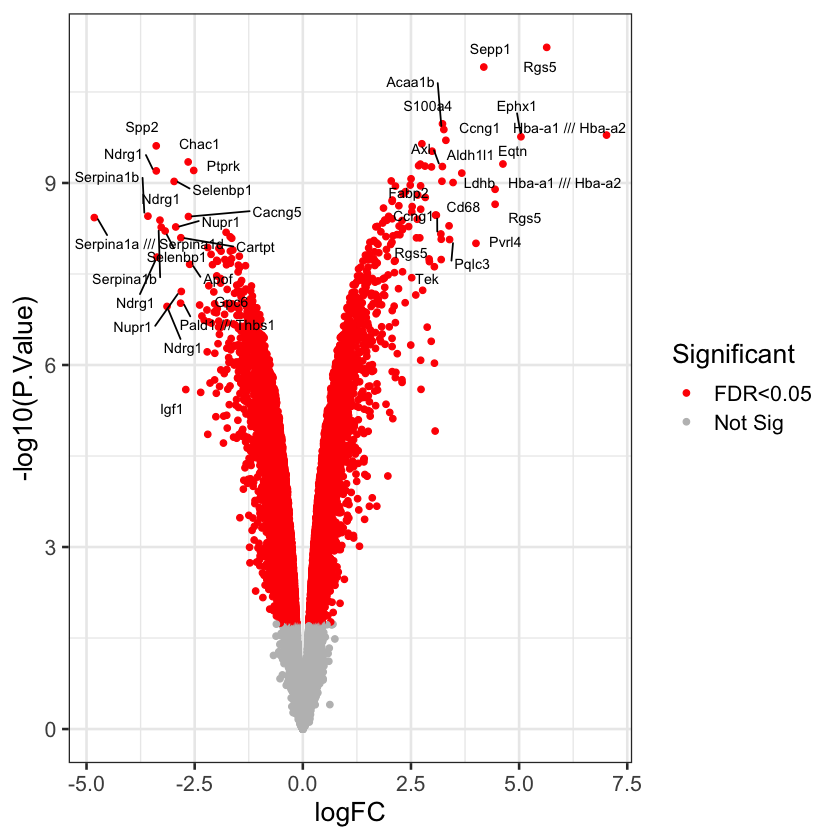

In [39]:
#Main code
file_list <- list.files(path = file_path, pattern = file_pattern)
file_list_with_path <- paste0(file_path, file_list)
for (file in file_list_with_path){
  volcano_plot(file)
}